In [0]:
import numpy as np
from sklearn.metrics import roc_curve
from sklearn.neighbors import KNeighborsClassifier
import random
import matplotlib.patheffects as PathEffects

In [0]:
from keras.layers import Input, Conv2D, Lambda, Dense, Flatten,MaxPooling2D, concatenate
from keras.models import Model, Sequential
from keras.regularizers import l2
from keras import backend as K
from keras.optimizers import SGD,Adam
from keras.losses import binary_crossentropy
import os
import pickle
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
from itertools import permutations
import seaborn as sns
from keras.datasets import mnist
from sklearn.manifold import TSNE
from sklearn.svm import SVC
import json


In [0]:
X_train=np.load('/content/drive/My Drive/X_train_with_glove.npy')
X_test=np.load('/content/drive/My Drive/X_test_with_glove.npy')

y_train=np.load('/content/drive/My Drive/y_train_with_glove.npy')
y_test=np.load('/content/drive/My Drive/y_test_with_glove.npy')

In [0]:
print(X_train.shape)
print(X_test.shape)

print(y_train.shape)
print(y_test.shape)

(3248, 3, 10100)
(458, 3, 10100)
(3248,)
(458,)


In [0]:
def triplet_loss(y_true, y_pred, alpha = 0.4):
    """
    Implementation of the triplet loss function
    Arguments:
    y_true -- true labels, required when you define a loss in Keras, you don't need it in this function.
    y_pred -- python list containing three objects:
            anchor -- the encodings for the anchor data
            positive -- the encodings for the positive data (similar to anchor)
            negative -- the encodings for the negative data (different from anchor)
    Returns:
    loss -- real number, value of the loss
    """

    print('y_pred.shape = ',y_pred)
    
    total_length = y_pred.shape.as_list()[-1]
    anchor = y_pred[:,0:int(total_length*1/3)]
    positive = y_pred[:,int(total_length*1/3):int(total_length*2/3)]
    negative = y_pred[:,int(total_length*2/3):int(total_length*3/3)]

    # distance between the anchor and the positive
    pos_dist = K.sum(K.square(anchor-positive),axis=1)

    # distance between the anchor and the negative
    neg_dist = K.sum(K.square(anchor-negative),axis=1)

    # compute loss
    basic_loss = pos_dist-neg_dist+alpha
    loss = K.maximum(basic_loss,0.0)
 
    return loss

In [0]:

def create_base_network(in_dims,a_dims,b_dims):
    """
    Base network to be shared.
    """
    inputs=Input(shape=(100,100,1),name="inputs")
    features_sub=Input(shape=(50,),name="sub_features")
    features_ob=Input(shape=(50,),name="ob_features")
    hidden1=Conv2D(16,(3,3),padding="same",activation="relu")(inputs)
    pool1=MaxPooling2D((2,2),padding="same")(hidden1)
    hidden2=Conv2D(64,(3,3),padding="same",activation="relu")(pool1)
    pool2=MaxPooling2D((2,2),padding="same")(hidden2)
    hidden3=Conv2D(128,(3,3),padding="same",activation="relu")(pool2)
    pool3=MaxPooling2D((2,2),padding="same")(hidden3)
    hidden4=Conv2D(256,(3,3),padding="same",activation="relu")(pool3)
    pool4=MaxPooling2D((2,2),padding="same")(hidden4)
    flat_features=Flatten(name="Flatten")(pool4)
    merged=concatenate([flat_features,features_sub,features_ob])
    output=Dense(15,name="embedding")(merged)
    model=Model(inputs=[inputs,features_sub,features_ob],outputs=output)
    return model
  

In [0]:
adam_optim = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999)

In [0]:
from keras import backend as K

def recall_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

def precision_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [0]:
anchor_input = Input((100,100,1,), name='anchor_input')
positive_input = Input((100,100,1, ), name='positive_input')
negative_input = Input((100,100,1, ), name='negative_input')

anchor_sub=Input((50,),name="anchor_sub")
positive_sub=Input((50,),name="positive_sub")
negative_sub=Input((50,),name="negative_sub")

anchor_ob=Input((50,),name="anchor_ob")
positive_ob=Input((50,),name="positive_ob")
negative_ob=Input((50,),name="negative_ob")

# Shared embedding layer for positive and negative items
Shared_DNN = create_base_network([100,100,1],[50],[50])
encoded_anchor = Shared_DNN(inputs=[anchor_input,anchor_sub,anchor_ob])
encoded_positive = Shared_DNN(inputs=[positive_input,positive_sub,positive_ob])
encoded_negative = Shared_DNN(inputs=[negative_input,negative_sub,negative_ob])
print(encoded_anchor.shape)
print(encoded_positive.shape)
print(encoded_negative.shape)

merged_vector = concatenate([encoded_anchor, encoded_positive, encoded_negative], axis=-1, name='merged_layer')

model = Model(inputs=[anchor_input,positive_input,negative_input,anchor_sub,positive_sub,negative_sub,anchor_ob,positive_ob,negative_ob], outputs=merged_vector)
model.compile(loss=triplet_loss, optimizer=adam_optim,metrics=['accuracy',f1_m,recall_m,precision_m])

(?, 15)
(?, 15)
(?, 15)
y_pred.shape =  Tensor("merged_layer_3/concat:0", shape=(?, 45), dtype=float32)


In [0]:
model.summary()

Model: "model_10"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
anchor_input (InputLayer)       (None, 100, 100, 1)  0                                            
__________________________________________________________________________________________________
anchor_sub (InputLayer)         (None, 50)           0                                            
__________________________________________________________________________________________________
anchor_ob (InputLayer)          (None, 50)           0                                            
__________________________________________________________________________________________________
positive_input (InputLayer)     (None, 100, 100, 1)  0                                            
___________________________________________________________________________________________

In [0]:
Anchor = X_train[:,0,:][:,:10000].reshape(-1,100,100,1)
Positive = X_train[:,1,:][:,:10000].reshape(-1,100,100,1)
Negative = X_train[:,2,:][:,:10000].reshape(-1,100,100,1)

Anchor_sub=X_train[:,0,:][:,10000:10050].reshape(-1,50)
Positive_sub=X_train[:,1,:][:,10000:10050].reshape(-1,50)
Negative_sub=X_train[:,2,:][:,10000:10050].reshape(-1,50)

Anchor_ob=X_train[:,0,:][:,10050:].reshape(-1,50)
Positive_ob=X_train[:,1,:][:,10050:].reshape(-1,50)
Negative_ob=X_train[:,2,:][:,10050:].reshape(-1,50)

Anchor_test = X_test[:,0,:][:,:10000].reshape(-1,100,100,1)
Positive_test = X_test[:,1,:][:,:10000].reshape(-1,100,100,1)
Negative_test = X_test[:,2,:][:,:10000].reshape(-1,100,100,1)

Anchor_test_sub=X_test[:,0,:][:,10000:10050].reshape(-1,50)
Positive_test_sub=X_test[:,1,:][:,10000:10050].reshape(-1,50)
Negative_test_sub=X_test[:,2,:][:,10000:10050].reshape(-1,50)

Anchor_test_ob=X_test[:,0,:][:,10050:].reshape(-1,50)
Positive_test_ob=X_test[:,1,:][:,10050:].reshape(-1,50)
Negative_test_ob=X_test[:,2,:][:,10050:].reshape(-1,50)

Y_dummy = np.empty((Anchor.shape[0],1))
Y_dummy2 = np.empty((Anchor_test.shape[0],1))

model.fit([Anchor,Positive,Negative,Anchor_sub,Positive_sub,Negative_sub,Anchor_ob,Positive_ob,Negative_ob],y=Y_dummy,validation_data=([Anchor_test,Positive_test,Negative_test,Anchor_test_sub,Positive_test_sub,Negative_test_sub,Anchor_test_ob,Positive_test_ob,Negative_test_ob],Y_dummy2), batch_size=32, epochs=200)

Train on 3248 samples, validate on 458 samples
Epoch 1/200
3248/3248 [==============================] - 4s 1ms/step - loss: 0.4555 - acc: 0.0169 - f1_m: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - val_loss: 0.4238 - val_acc: 0.0306 - val_f1_m: 43.1457 - val_recall_m: 21.5729 - val_precision_m: 4316375474.3057
Epoch 2/200
3248/3248 [==============================] - 3s 928us/step - loss: 0.4075 - acc: 0.0234 - f1_m: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - val_loss: 0.4162 - val_acc: 0.0480 - val_f1_m: 46.7708 - val_recall_m: 23.3854 - val_precision_m: 4734148417.9563
Epoch 3/200
3248/3248 [==============================] - 3s 929us/step - loss: 0.3593 - acc: 0.0607 - f1_m: 0.0000e+00 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - val_loss: 0.4148 - val_acc: 0.0764 - val_f1_m: 45.8173 - val_recall_m: 23.0235 - val_precision_m: 3807772937.8515
Epoch 4/200
3248/3248 [==============================] - 3s 928us/step - loss: 0.3084 - acc: 0.0400 - f

In [0]:
model.save_weights("model_weight.hdf5")

In [0]:
trained_model = Model(inputs=[anchor_input,anchor_sub,anchor_ob], outputs=encoded_anchor)

In [0]:
trained_model.load_weights('/content/model_weight.hdf5')

In [0]:
from sklearn.preprocessing import LabelBinarizer
le=LabelBinarizer()
y_train_onehot=le.fit_transform(y_train)
y_test_onehot=le.fit_transform(y_test)
print(y_train_onehot.shape)
print(y_test_onehot.shape)

(3248, 4)
(458, 4)


In [0]:
X_train_trm = trained_model.predict([X_train[:,0,:][:,:10000].reshape(-1,100,100,1),X_train[:,0,:][:,10000:10050].reshape(-1,50),X_train[:,0,:][:,10050:].reshape(-1,50)])
X_test_trm = trained_model.predict([X_test[:,0,:][:,:10000].reshape(-1,100,100,1),X_test[:,0,:][:,10000:10050].reshape(-1,50),X_test[:,0,:][:,10050:].reshape(-1,50)])

Classifier_input = Input((7,))

Classifier_output = Dense(4, activation='softmax')(Classifier_input)
Classifier_model = Model(Classifier_input, Classifier_output)


Classifier_model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy',f1_m,recall_m,precision_m])

Classifier_model.fit(X_train_trm,y_train_onehot, validation_data=(X_test_trm,y_test_onehot),epochs=100)

Train on 3248 samples, validate on 458 samples
Epoch 1/100
3248/3248 [==============================] - 1s 313us/step - loss: 1.6229 - acc: 0.2371 - f1_m: 0.0876 - recall_m: 0.0597 - precision_m: 0.1757 - val_loss: 1.5947 - val_acc: 0.2162 - val_f1_m: 0.0731 - val_recall_m: 0.0480 - val_precision_m: 0.1590
Epoch 2/100
3248/3248 [==============================] - 0s 138us/step - loss: 1.4977 - acc: 0.2869 - f1_m: 0.0909 - recall_m: 0.0570 - precision_m: 0.2380 - val_loss: 1.4820 - val_acc: 0.2664 - val_f1_m: 0.0807 - val_recall_m: 0.0480 - val_precision_m: 0.2809
Epoch 3/100
3248/3248 [==============================] - 0s 130us/step - loss: 1.4177 - acc: 0.3199 - f1_m: 0.0885 - recall_m: 0.0526 - precision_m: 0.3151 - val_loss: 1.4067 - val_acc: 0.3166 - val_f1_m: 0.0878 - val_recall_m: 0.0502 - val_precision_m: 0.4346
Epoch 4/100
3248/3248 [==============================] - 0s 130us/step - loss: 1.3662 - acc: 0.3534 - f1_m: 0.0815 - recall_m: 0.0474 - precision_m: 0.3135 - val_loss: 1.

In [0]:
Classifier_model.evaluate(x=X_test_trm,y=y_test_onehot)

458/458 [==============================] - 0s 82us/step


[1.2254986232024614,
 0.4104803494751193,
 0.004234484189462454,
 0.002183406113537118,
 0.06986898730415445]

In [0]:
Classifier_model.metrics_names

['loss', 'acc', 'f1_m', 'recall_m', 'precision_m']

In [0]:
!wget http://imagenet.stanford.edu/internal/jcjohns/scene_graphs/sg_dataset.zip

--2019-12-02 00:13:01--  http://imagenet.stanford.edu/internal/jcjohns/scene_graphs/sg_dataset.zip
Resolving imagenet.stanford.edu (imagenet.stanford.edu)... 171.64.68.16
Connecting to imagenet.stanford.edu (imagenet.stanford.edu)|171.64.68.16|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2000609775 (1.9G) [application/zip]
Saving to: ‘sg_dataset.zip.1’

sg_dataset.zip.1      0%[                    ]  15.02M  6.06MB/s               ^C


In [ ]:
!unzip /content/sg_dataset.zip


In [0]:
import imageio
filename = "sg_dataset/sg_train_images/2637269067_618d25375b_o.jpg"
subject = "banana"
predicate = "next"
obj = "bottle"
img = imageio.imread(filename)

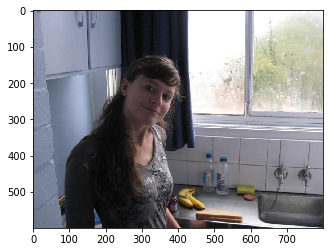

In [0]:
plt.imshow(img)
plt.show()

In [0]:
%load_ext autoreload
%autoreload 2
import torchvision
import cv2
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
model2 = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
model2.eval()

In [0]:
COCO_INSTANCE_CATEGORY_NAMES = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A',
    'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
    'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table',
    'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book',
    'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]

In [0]:
from PIL import Image
def get_prediction(img_path, threshold):
  img = Image.open(img_path) # Load the image
  transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()]) # Defing PyTorch Transform
  img = transform(img) # Apply the transform to the image
  pred = model2([img]) # Pass the image to the model
  pred_class = [COCO_INSTANCE_CATEGORY_NAMES[i] for i in list(pred[0]['labels'].numpy())] # Get the Prediction Score
  pred_boxes = [[(i[0], i[1]), (i[2], i[3])] for i in list(pred[0]['boxes'].detach().numpy())] # Bounding boxes
  pred_score = list(pred[0]['scores'].detach().numpy())
  pred_t = [pred_score.index(x) for x in pred_score if x > threshold][-1] # Get list of index with score greater than threshold.
  pred_boxes = pred_boxes[:pred_t+1]
  pred_class = pred_class[:pred_t+1]
  return pred_boxes, pred_class

In [0]:
import numpy as np
def object_detection_api(img_path, sub, obj, threshold=0.5, rect_th=3, text_size=3, text_th=3):
  print("here")
  boxes, pred_cls = get_prediction(img_path, threshold) # Get predictions
  img = cv2.imread(img_path) # Read image with cv2
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # Convert to RGB
  
  sub_list=[]
  obj_list=[]

  for i in range(len(boxes)):
    print(pred_cls[i])
    if(pred_cls[i]==sub):
      sub_list.append(i)
    if(pred_cls[i]==obj):
      obj_list.append(i)

  imgList = []
  # print(sub_list)
  # print(obj_list)

  for i1 in range(len(sub_list)):
    for j1 in range(len(obj_list)):
      print(i1," ",j1)
      if(sub_list[i1]==obj_list[j1]):
        continue
      plt.clf()
      img1 = np.array(img)
      img2 = np.array(img)
      img1 = img1*0.0
      i = sub_list[i1]
      # print(boxes[i])
      # print(int(min(boxes[i][1]))," ",int(max(boxes[i][1]))," : ",int(min(boxes[i][0]))," ",int(max(boxes[i][0])))
      img_bbox = np.zeros(shape=[8], dtype=np.int32)
      img_bbox[0] = int(min(boxes[i][0][1], boxes[i][1][1]))
      img_bbox[1] = int(max(boxes[i][0][1], boxes[i][1][1]))
      img_bbox[2] = int(min(boxes[i][0][0], boxes[i][1][0]))
      img_bbox[3] = int(max(boxes[i][0][0], boxes[i][1][0]))
      img1[int(min(boxes[i][0][1], boxes[i][1][1])):int(max(boxes[i][0][1], boxes[i][1][1])), int(min(boxes[i][0][0], boxes[i][1][0])):int(max(boxes[i][0][0], boxes[i][1][0]))] = 0.5
      
      i = obj_list[j1]
      # print(boxes[i])
      img_bbox[4] = int(min(boxes[i][0][1], boxes[i][1][1]))
      img_bbox[5] = int(max(boxes[i][0][1], boxes[i][1][1]))
      img_bbox[6] = int(min(boxes[i][0][0], boxes[i][1][0]))
      img_bbox[7] = int(max(boxes[i][0][0], boxes[i][1][0]))

      imgList.append(img_bbox)

      # print(int(min(boxes[i][1]))," ",int(max(boxes[i][1]))," : ",int(min(boxes[i][0]))," ",int(max(boxes[i][0])))
      img1[int(min(boxes[i][0][1], boxes[i][1][1])):int(max(boxes[i][0][1], boxes[i][1][1])), int(min(boxes[i][0][0], boxes[i][1][0])):int(max(boxes[i][0][0], boxes[i][1][0]))] += 1.0
      img1[int(min(boxes[i][0][1], boxes[i][1][1])):int(max(boxes[i][0][1], boxes[i][1][1])), int(min(boxes[i][0][0], boxes[i][1][0])):int(max(boxes[i][0][0], boxes[i][1][0]))] /= 2.0
      img1[int(min(boxes[i][0][1], boxes[i][1][1])):int(max(boxes[i][0][1], boxes[i][1][1])), int(min(boxes[i][0][0], boxes[i][1][0])):int(max(boxes[i][0][0], boxes[i][1][0]))] /= 0.75
      # plt.subplot(121)
      # plt.imshow(img1)
      

      i = sub_list[i1]
      cv2.rectangle(img2, boxes[i][0], boxes[i][1],color=(0, 255, 0), thickness=rect_th) # Draw Rectangle with the coordinates
      cv2.putText(img2,pred_cls[i], boxes[i][0],  cv2.FONT_HERSHEY_SIMPLEX, text_size, (0,255,0),thickness=text_th) # Write the prediction class

      

      
      i = obj_list[j1]

      cv2.rectangle(img2, boxes[i][0], boxes[i][1],color=(0, 255, 0), thickness=rect_th) # Draw Rectangle with the coordinates
      cv2.putText(img2,pred_cls[i], boxes[i][0],  cv2.FONT_HERSHEY_SIMPLEX, text_size, (0,255,0),thickness=text_th) # Write the prediction class
      # plt.subplot(122)
      # plt.imshow(img2)
      # plt.show()
  
  final_img_bbox = np.zeros(shape=[len(imgList),8], dtype=np.int32)
  for i in range(len(imgList)):
    final_img_bbox[i,:] = imgList[i]
  return final_img_bbox

In [0]:
def rgb2gray(rgb):
      return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])  


here
person
bottle
banana
bottle
sandwich
sink
bottle
0   0
0   1
0   2


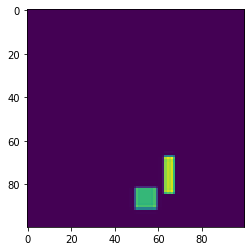

[[0.34211048 0.40512177 0.1811652  0.07160251]]


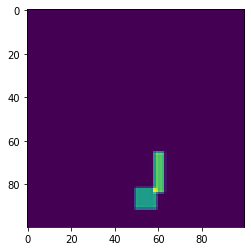

[[0.3241319  0.42244178 0.17100213 0.08242419]]


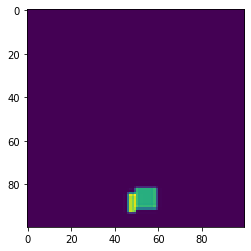

[[0.39079693 0.37540415 0.14799595 0.08580296]]


In [0]:
bboxes = object_detection_api(filename, subject, obj)

for i in range(bboxes.shape[0]):
  img1 = np.array(img)
  img1 = img1*0.0

  img1[bboxes[i,0]:bboxes[i,1], bboxes[i,2]:bboxes[i,3]] = 0.5    
  img1[bboxes[i,4]:bboxes[i,5], bboxes[i,6]:bboxes[i,7]] += 1.0
  img1[bboxes[i,4]:bboxes[i,5], bboxes[i,6]:bboxes[i,7]] /= 2.0
  img1[bboxes[i,4]:bboxes[i,5], bboxes[i,6]:bboxes[i,7]] /= 0.75
  img1 = rgb2gray(img1)
  img1 = np.array((img1 * 255).astype(np.uint8))
  img1 = Image.fromarray(img1)
  img1 = img1.resize((100, 100), Image.ANTIALIAS)

  img1 = np.array(img1)
  img1 = img1/255.0
  
  plt.imshow(img1)
  plt.show()

  img1 = np.reshape(img1, newshape=[1,img1.shape[0],img1.shape[1],1])

  X_trm = trained_model.predict(img1)
  y_pred = Classifier_model.predict(x=X_trm)
  print(y_pred)

In [0]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
